<h1> PROJECT MACHINE LEARNING </h1>

<h4> Import the necessary packages </h4>

In [1]:
import numpy as np
import pandas as pd
import joblib

import plotly.express as px
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

<h4> Define the file path of the csv data file </h4>

In [2]:
file_path = "../Dataset/books.csv"

<h2> Data Trasformation part </h2>

In [3]:
books = pd.read_csv(file_path, sep=',')
test = pd.read_csv(file_path, sep=',')

In [4]:
# gets the data type of each column
books.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
  num_pages             int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

<h4> Rename the num_pages column </h4>

In [5]:
books.rename(columns={"  num_pages": "num_pages"}, inplace=True)

In [6]:
books.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

<h4> Search for invalide date and turn it to NaT </h4>

In [7]:
try:
    # Convert the 'publication_date' column to datetime with 'coerce' option to handle invalid dates
    books['publication_date'] = pd.to_datetime(books['publication_date'], errors='coerce')
    
    # Find rows with invalid dates
    invalid_dates = books[books['publication_date'].isnull()]
    
    # Print the rows with invalid dates
    print(invalid_dates[['bookID', 'average_rating', 'publication_date']])
    
except Exception as e:
    print(e)


       bookID  average_rating publication_date
8180    31373            4.10              NaT
11098   45531            3.96              NaT


In [8]:
new_types_dict = {"title":"string", "authors":"string", "language_code":"category", "publisher":"category","isbn":"string", "isbn13":"string","average_rating":"float64","num_pages":"int64", "ratings_count":"int64","text_reviews_count":"int64","publication_date": "datetime64[ns]"}

# turn the books dataframe into a dataframe with the new types
books = books.astype(new_types_dict)
books.dtypes

bookID                         int64
title                         string
authors                       string
average_rating               float64
isbn                          string
isbn13                        string
language_code               category
num_pages                      int64
ratings_count                  int64
text_reviews_count             int64
publication_date      datetime64[ns]
publisher                   category
dtype: object

<h4> Make language code lowercase </h4>

In [9]:
books["language_code"] = books["language_code"].str.lower()

# print all values of books["language_code"] distinct with their occurence count
books["language_code"].value_counts()

eng      8911
en-us    1409
spa       218
en-gb     214
fre       144
ger        99
jpn        46
mul        19
zho        14
grc        11
por        10
en-ca       7
ita         5
enm         3
lat         3
swe         2
rus         2
srp         1
nl          1
msa         1
glg         1
wel         1
ara         1
nor         1
tur         1
gla         1
ale         1
Name: language_code, dtype: int64

<p> I decided to only take the 7 most used languages, and leave out the rest of the books in order to shorten the number of different languages and to do a <b> One hot encoding </b> on the books' languages afterwards </p>

In [10]:
# Only keep the rows where the language is in the top 7 most common languages
books = books[books['language_code'].isin(['eng', 'en-us', 'spa', 'en-gb', 'fre', 'ger', 'jpn'])]

In [11]:
# print all values of books["language_code"] distinct with their occurence count
books["language_code"].value_counts()

eng      8911
en-us    1409
spa       218
en-gb     214
fre       144
ger        99
jpn        46
Name: language_code, dtype: int64

<h4> Verify if there are null values </h4>

In [12]:
books.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      2
publisher             0
dtype: int64

In [13]:
books[books['publication_date'].isnull()]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
8180,31373,In Pursuit of the Proper Sinner (Inspector Lyn...,Elizabeth George,4.10,0553575104,9780553575101,eng,718,10608,295,NaT,Bantam Books
11098,45531,Montaillou village occitan de 1294 à 1324,Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie,3.96,2070323285,9782070323289,fre,640,15,2,NaT,Folio histoire


<h2> Data Analysis part </h2>

In [14]:
pd.options.display.float_format = '{:.2f}'.format
books.describe()[['average_rating', 'ratings_count', 'text_reviews_count']]

,average_rating,ratings_count,text_reviews_count
count,11041.00,11041.00,11041.00
mean,3.93,18068.83,545.71
std,0.35,112906.44,2585.80
min,0.00,0.00,0.00
25%,3.77,107.00,9.00
50%,3.96,757.00,47.00
75%,4.13,5036.00,241.00
max,5.00,4597666.00,94265.00


In [15]:
books.corr(numeric_only = True)

,bookID,average_rating,num_pages,ratings_count,text_reviews_count
bookID,1.00,-0.04,-0.02,-0.08,-0.08
average_rating,-0.04,1.00,0.15,0.04,0.03
num_pages,-0.02,0.15,1.00,0.03,0.04
ratings_count,-0.08,0.04,0.03,1.00,0.87
text_reviews_count,-0.08,0.03,0.04,0.87,1.00


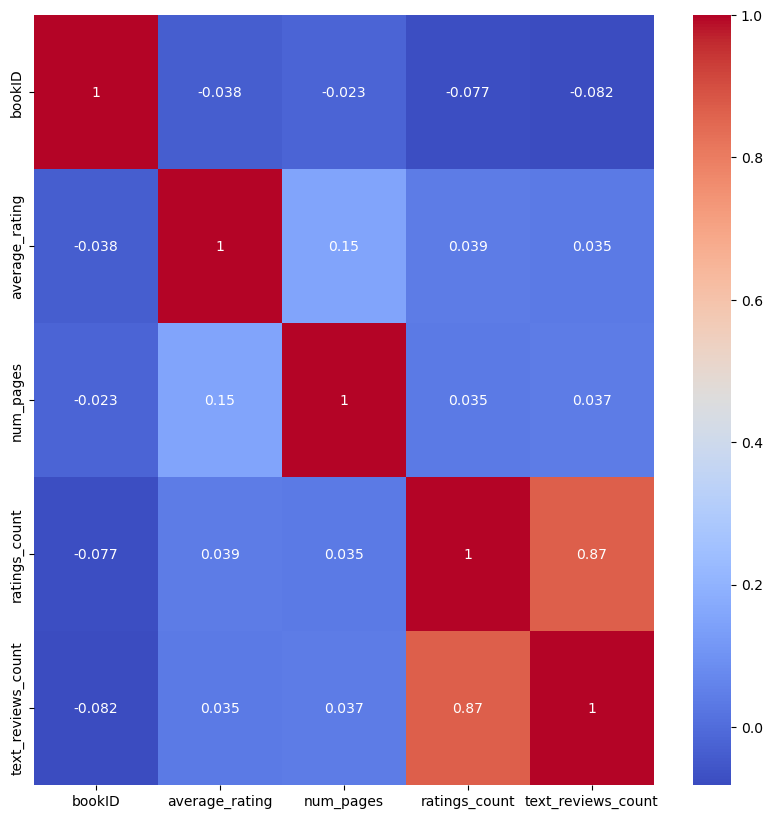

In [16]:
plt.figure(figsize=(10, 10))
sns.heatmap(books.corr(numeric_only = True), annot=True, cmap='coolwarm')
plt.show()

<p> From the outputs above, we can deduce that the ratings count has a high correlation coefficient with the text_reviews_count </p>

In [17]:
px.scatter(data_frame=books,x='ratings_count',y='text_reviews_count',color='language_code',title='reviews_count vs text_reviews_count')

<p> From the scatterplot, we can confirm that the higher the ratings count, the higher are the text_reviews_count, which is logic </p>

In [18]:
px.scatter(data_frame=books,x='average_rating',y='ratings_count',color='text_reviews_count',title='Average Rating vs Ratings Count')

<p> Here, I decided to remove some outliers to improve the dataset </p>

In [19]:
books = books[(books['text_reviews_count'] != 94265) & (books['average_rating'] != 3.59)]
books = books[(books['average_rating'] != 0 ) & (books['ratings_count'] != 0)]
books = books[(books['average_rating'] != 1 ) & (books['ratings_count'] != 1)]

In [20]:
px.scatter(data_frame=books,x='average_rating',y='ratings_count',color='text_reviews_count',title='Average Rating vs Ratings Count (outliers removed)')

In [21]:
px.scatter(data_frame=books, x='average_rating', y='num_pages', color='language_code', title='Average Rating vs. Number of Pages')

In [22]:
px.scatter(data_frame=books, x='publication_date', y='average_rating', color='language_code', title='Average Rating vs. Publication Date')

<h3> Analysis of the authors column </h3>

In [23]:
books["authors"].unique()

<StringArray>
[                                 'J.K. Rowling/Mary GrandPré',
                                                'J.K. Rowling',
                                      'W. Frederick Zimmerman',
                                               'Douglas Adams',
                                   'Douglas Adams/Stephen Fry',
                                                 'Bill Bryson',
                                              'J.R.R. Tolkien',
                                    'J.R.R. Tolkien/Alan  Lee',
               'Chris   Smith/Christopher  Lee/Richard Taylor',
                                                 'Jude Fisher',
 ...
                         'Stephen E. Ambrose/Barrett Whitener',
                                              'Sam R. Watkins',
                                            'Alexander Hunter',
                                    'Roald Dahl/Horacio Elena',
                                       'David Wood/Roald Dahl',
                     

<p> We can see that there are more than one authors working on a same book, the authors are separated by the slash symbol, so the best thing to do to valorize them is to duplicates the rows where there are many authors, and assign an unique author to each row (example, <b> Harry Potter and the Half blood Prince </b> is now duplicated into two lines, with the first line having the author as <b> J.K Rowling </b>, while the other one has <b> Mary GrandPré </b>) </p>

In [24]:
# Split authors and duplicate rows
new_rows = []
for index, row in books.iterrows():
    authors = row['authors'].split('/')
    for author in authors:
        new_row = row.copy()
        new_row['authors'] = author
        new_rows.append(new_row)

# Create a new DataFrame
books = pd.DataFrame(new_rows)

# Reset index
books.reset_index(drop=True, inplace=True)

In [25]:
books.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.
1,1,Harry Potter and the Half-Blood Prince (Harry ...,Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.
3,2,Harry Potter and the Order of the Phoenix (Har...,Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,2003-11-01,Scholastic


In [26]:
books["authors"].value_counts()

Stephen King           98
William Shakespeare    93
J.R.R. Tolkien         53
P.G. Wodehouse         47
Agatha Christie        47
                       ..
Isabel Margelí          1
Maja Ueberle-Pfaff      1
Billy Mills             1
Jodi Cobb               1
Michael Hemmingson      1
Name: authors, Length: 8974, dtype: int64

<h2> Machine Learning - Decision Tree Regressor</h2>

<p> Why did I choose to use Decision Tree? </p>
<ul>
    <li> Decision trees can capture complex relationships between features and the target </li>
    <li> It can handle both categorical and numerical features naturally. In our case, we have a mix of data types like "language_code", "publisher", "average_rating" and so on ... </li>
    <li> It is easy to implement </li>
    <li> I consider it as a "first step" for a more advanced method like Random Forest, should the need arise </li>
</ul>

In [27]:
books_decisionTree = books.copy()

In [28]:
books_decisionTree.index

RangeIndex(start=0, stop=18687, step=1)

In [29]:
# We find the missing indexes

full_range = set(range(len(books_decisionTree.index)))
missing_numbers = full_range - set(books_decisionTree.index)
print(f"There are {len(missing_numbers)} missing indexes")

missing_numbers_list = list(missing_numbers)
missing_numbers_list.sort()
for i in range(0, len(missing_numbers_list), 10):
    print(missing_numbers_list[i:i+10])

There are 0 missing indexes


In [30]:
drop_columns = ['bookID', 'title', 'isbn', 'isbn13', 'publication_date']

books_decisionTree.drop(columns = drop_columns, inplace = True)

<h3> Feature engineering: </h3>

<ol>
    <li> Top 7 language codes earlier are encoded using the one hot method </li>
    <li> Label Encoding for publisher, since there are so many publishers, using One Hot Encoding would make the data set too heavy </li>
</ol>

In [31]:
# One hot encoding for language_codeS
books_decisionTree = pd.get_dummies(books_decisionTree, columns=["language_code"])

# Label encoding for 'publisher'
le = LabelEncoder()

books_decisionTree['publisher'] = le.fit_transform(books_decisionTree['publisher'])

# Drop the 'publisher' column
books_decisionTree.drop(columns=['publisher'], inplace=True)

# Label encoding for 'authors'
le = LabelEncoder()

books_decisionTree['authors_encoded'] = le.fit_transform(books_decisionTree['authors'])

# Drop the 'authors' column
books_decisionTree.drop(columns=['authors'], inplace=True)

In [32]:
# Splitting the dataset into training (80%) and testing (20%) sets
train_df, test_df = train_test_split(books_decisionTree, test_size=0.2, random_state=42)

In [34]:
# Define features and target variable
features = books_decisionTree.drop(columns=['average_rating'])
target = books_decisionTree['average_rating']

## Machine Learning - Decision Tree Regressor

In [35]:
# Initialize the Decision Tree regressor
regressor = DecisionTreeRegressor(random_state=42)

# Train the Decision Tree regressor
regressor.fit(train_df[features.columns], train_df['average_rating'])

# Make predictions on the test set
predictions = regressor.predict(test_df[features.columns])

In [36]:
# Calculate mean squared error
mse = mean_squared_error(test_df['average_rating'], predictions)
print(f"Mean Squared Error of Decision Tree Regressor: {mse:.2f}")

mae = mean_absolute_error(test_df['average_rating'], predictions)
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(test_df['average_rating'], predictions)
print(f"R-squared: {r2:.2f}")

cv = np.std(predictions) / np.mean(predictions)
print(f"Coefficient of Variation: {cv:.2f}")

Mean Squared Error of Decision Tree Regressor: 0.09
Mean Absolute Error: 0.18
R-squared: -0.06
Coefficient of Variation: 0.08


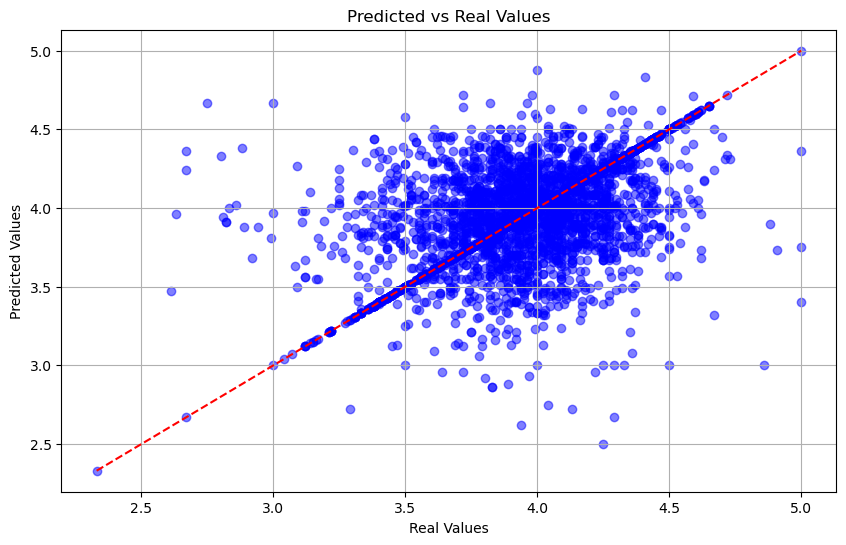

In [37]:
# Get the real values from the test set
real_values = test_df['average_rating']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(real_values, predictions, color='blue', alpha=0.5)
plt.title('Predicted vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Add a diagonal line for reference
x = np.linspace(min(real_values), max(real_values), 100)
plt.plot(x, x, color='red', linestyle='--')

plt.show()

<p> Judging from the plot above, we can see some promising results from the Decision Tree algorithm's output. However, there seem to be so much noise and so many outliers. The R-squared value being just 0.33 indicates that this is not a good fit for our data </p>

<p> From the result above, I decided to use the Random Forest Regressor algorithm, which builds multiple decision trees and combines their predictions to improve the overall performance of the model. It will reduce the impact of individual noisy or outlier-prone trees. This helps the model generalize better to new data, leading to improved accuracy on unseen instances. </p>

<h2> Machine Learning - Random Forest Regressor </h2>

In [38]:
books_randomForest = books.copy()

In [39]:
drop_columns = ['bookID', 'title', 'isbn', 'isbn13', 'publication_date']

books_randomForest.drop(columns = drop_columns, inplace = True)

In [40]:
# One hot encoding for language_code
books_randomForest = pd.get_dummies(books_randomForest, columns=["language_code"])

# Label encoding for 'publisher'
le = LabelEncoder()

books_randomForest['publisher'] = le.fit_transform(books_randomForest['publisher'])

# Drop the 'publisher' column
books_randomForest.drop(columns=['publisher'], inplace=True)

# Label encoding for 'authors'
le = LabelEncoder()

books_randomForest['authors_encoded'] = le.fit_transform(books_randomForest['authors'])

# Drop the 'authors' column
books_randomForest.drop(columns=['authors'], inplace=True)

In [74]:
# Splitting the dataset into training (80%) and testing (20%) sets
train_df, test_df = train_test_split(books_randomForest, test_size=0.2, random_state=42)

In [75]:
# export the datasets for the deployment part
train_df.to_csv('../Dataset/train_df.csv')
test_df.to_csv('../Dataset/test_df.csv')

In [65]:
# Define features and target variable
features = train_df.drop(columns=['average_rating'])
target = train_df['average_rating']

In [66]:
# Initialize the RandomForestRegressor
random_forest = RandomForestRegressor(random_state=42)

In [67]:
# Train the model
random_forest.fit(features, target)

RandomForestRegressor(random_state=42)

In [68]:
# Predict on the test set
test_features = test_df.drop(columns=['average_rating'])
predictions = random_forest.predict(test_features)

In [71]:
# Calculate mean squared error
mse = mean_squared_error(test_df['average_rating'], predictions)
print(f"Mean Squared Error of Random Forest Regressor: {mse:.2f}")

mae = mean_absolute_error(test_df['average_rating'], predictions)
print(f"Mean Absolute Error: {mae:.2f}")

r2 = r2_score(test_df['average_rating'], predictions)
print(f"R-squared: {r2:.2f}")

cv = np.std(predictions) / np.mean(predictions)
print(f"Coefficient of Variation: {cv:.2f}")

Mean Squared Error of Random Forest Regressor: 0.05
Mean Absolute Error: 0.15
R-squared: 0.44
Coefficient of Variation: 0.05


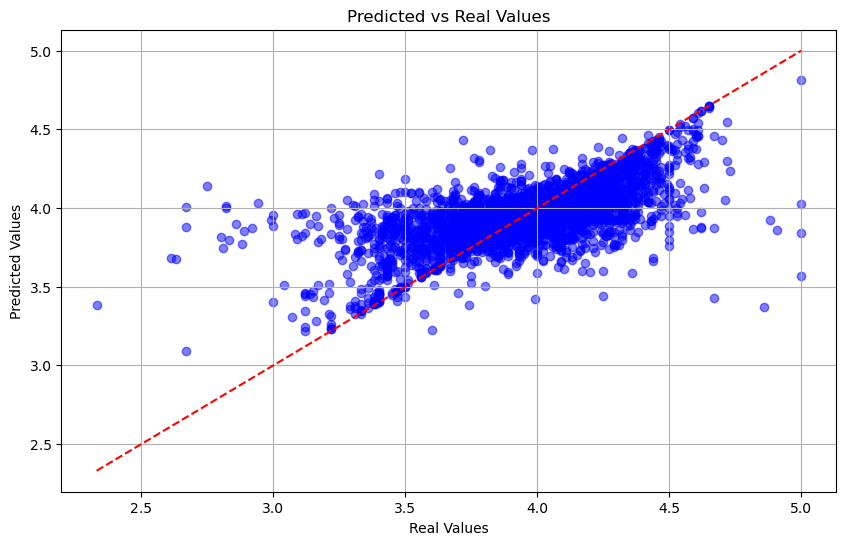

In [72]:
# Get the real values from the test set
real_values = test_df['average_rating']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(real_values, predictions, color='blue', alpha=0.5)
plt.title('Predicted vs Real Values')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.grid(True)

# Add a diagonal line for reference
x = np.linspace(min(real_values), max(real_values), 100)
plt.plot(x, x, color='red', linestyle='--')

plt.show()

Looking at the plot above, we can deduce that the Random Forest algorithm fits what we want immediately. There is a great correlation between the predicted value and the real value, along with the stats above (mse, mae, ...) all returns great values.

Once the model chosen, we proceed to save it using the joblib module.

In [73]:
with open("random_forest.joblib","wb") as fout:
    model = joblib.dump(random_forest, fout)